In [1]:
from datetime import datetime
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib
import hail as hl
from hail.plot import show
from hail.linalg import BlockMatrix

Loading BokehJS ...

In [2]:
DATASET = os.getenv('WORKSPACE_CDR')
bucket = os.getenv('WORKSPACE_BUCKET')

In [3]:
# set up hail
hl.init(default_reference = "GRCh38")

/opt/conda/lib/python3.10/site-packages/hail/context.py:352: UserWarning:

Using hl.init with a default_reference argument is deprecated. To set a default reference genome after initializing hail, call `hl.default_reference` with an argument to set the default reference genome.

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:33839
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing

In [4]:
np.random.seed(123)

### Continuous Phenotype R2

In [5]:
Sample_all_quant = pd.read_csv(f"{bucket}/Pheno/quant_all.tsv",sep = "\t", index_col="person_id")

HDL_df = pd.read_csv(f"{bucket}/Scores/WGS/HDL_clump_AFR.gz",sep = "\t", index_col="s")

In [7]:
def Select_threshold_quant(phenodf_anc_val, phenodf_anc_val_COVs, phenodf_anc_val_PHE):
    PGSs = ['pgs1', 'pgs2', 'pgs3', 'pgs4','pgs5', 'pgs6', 'pgs7', 'pgs8', 'pgs9', 'pgs10']
    R2_val = np.empty([10])
    R2_val[:] = np.nan
    for j in range(len(PGSs)):
        phenodf_anc_val_COVs_PGS = pd.concat([phenodf_anc_val_COVs, phenodf_anc_val[[PGSs[j]]]], axis = 1)
        model0_val = sm.OLS(phenodf_anc_val_PHE, phenodf_anc_val_COVs, missing = 'drop').fit()
        model1_val = sm.OLS(phenodf_anc_val_PHE, phenodf_anc_val_COVs_PGS, missing = 'drop').fit()
        R2_val[j] = model1_val.rsquared - model0_val.rsquared
    best_thresh =  "pgs" + str(np.argmax(R2_val) + 1)
    return best_thresh

In [8]:
def Compute_R2_CV_quant(phenodf, pheno, anc):
    PGSs = ['pgs1', 'pgs2', 'pgs3', 'pgs4','pgs5', 'pgs6', 'pgs7', 'pgs8', 'pgs9', 'pgs10']
    PHE = pheno
    COVs = ['Age', 'is_sex_Male', 'is_sex_Female', 'PC1', 'PC2', 'PC3', 'PC4',
           'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
           'PC14', 'PC15', 'PC16']
    phenodf_anc = phenodf.loc[ (Sample_all_quant["is_anc_pred_" + anc] == 1) & (~phenodf[pheno].isna())] 
    phenodf_anc.loc[:,"bin"] = np.random.randint(0,10,size=len(phenodf_anc))
    
    R2_test = np.empty([10])
    thresholds = [None] * 10
    R2_test[:] = np.nan

    for i in range(0, 10):
        phenodf_anc_val = phenodf_anc.loc[phenodf_anc.bin == i,]
        phenodf_anc_val_COVs = sm.add_constant(phenodf_anc_val.loc[:, COVs].astype("float"))
        phenodf_anc_val_PHE = phenodf_anc_val[PHE].astype("float")
        
        best_thresh = Select_threshold_quant(phenodf_anc_val, phenodf_anc_val_COVs, phenodf_anc_val_PHE)
        thresholds[i] = best_thresh
        phenodf_anc_test = phenodf_anc.loc[phenodf_anc.bin != i,]
        phenodf_anc_test_COVs = sm.add_constant(phenodf_anc_test.loc[:, COVs].astype("float"))
        phenodf_anc_test_COVs_bestPGS = sm.add_constant(phenodf_anc_test.loc[:, COVs + [best_thresh]].astype("float"))
        phenodf_anc_test_PHE = phenodf_anc_test[PHE].astype("float")
        
        model0_test = sm.OLS(phenodf_anc_test_PHE, phenodf_anc_test_COVs, missing = 'drop').fit()
        model1_test = sm.OLS(phenodf_anc_test_PHE, phenodf_anc_test_COVs_bestPGS, missing = 'drop').fit()
        R2_test[i] = model1_test.rsquared - model0_test.rsquared

    return(R2_test, thresholds)

In [9]:
def Make_df2plot(phenodf, pheno):
    ancs = ["afr"]
    df2plot = pd.DataFrame(index=range(0),columns=range(4))
    df2plot.columns = ["pheno", "anc", "R2", "threshold"]
    for anc in ancs:
        if pheno in ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]:
            R2_thresh = Compute_R2_CV_quant(phenodf, pheno, anc)
        elif pheno in ["T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]:
            R2_thresh = Compute_R2_CV_binary(phenodf, pheno, anc)
        
        df2plot_anc = pd.concat([pd.Series([pheno]*10, name = "pheno"), 
                                 pd.Series([anc]*10, name = "anc"), 
                                 pd.Series(R2_thresh[0], name = "R2"), 
                                 pd.Series(R2_thresh[1], name = "threshold")], axis = 1)
        df2plot = pd.concat([df2plot, df2plot_anc], axis = 0)

    return df2plot 

In [10]:
df2plot_quant = pd.concat([
                     Make_df2plot(HDL_df, "HDL")],
                   axis = 0)

/tmp/ipykernel_1117/1822597900.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# Calculate the mean R2 value
mean_r2 = df2plot_quant['R2'].mean()

print(f"Mean R2 for HDL: {mean_r2}")

Mean R2 for HDL: 0.0101587420680898


In [13]:
# Rename the 'anc' column to 'Ancestry'
df2plot_quant.rename(columns={'anc': 'Ancestry'}, inplace=True)

# Change the values in the 'Ancestry' column
df2plot_quant['Ancestry'] = df2plot_quant['Ancestry'].replace({'eur': 'EUR', 'amr': 'AMR', 'afr': 'AFR'})

In [15]:
array_quant = pd.read_csv(f"{bucket}/R2/array_quant.tsv",sep = "\t")
wgs_quant = pd.read_csv(f"{bucket}/R2/wgs_quant.tsv",sep = "\t")

In [18]:
array_quant_HDL_AFR = array_quant[(array_quant['pheno'] == 'HDL') & (array_quant['Ancestry'] == 'AFR')]
wgs_quant_HDL_AFR = wgs_quant[(wgs_quant['pheno'] == 'HDL') & (wgs_quant['Ancestry'] == 'AFR')]

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

array_quant_HDL_AFR['Source'] = 'Array'
wgs_quant_HDL_AFR['Source'] = 'WGS'
df2plot_quant['Source'] = 'WGS (AFR-specific QC)'

/tmp/ipykernel_1117/242063073.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# Combine the two datasets
quant_df = pd.concat([array_quant_HDL_AFR, wgs_quant_HDL_AFR, df2plot_quant])

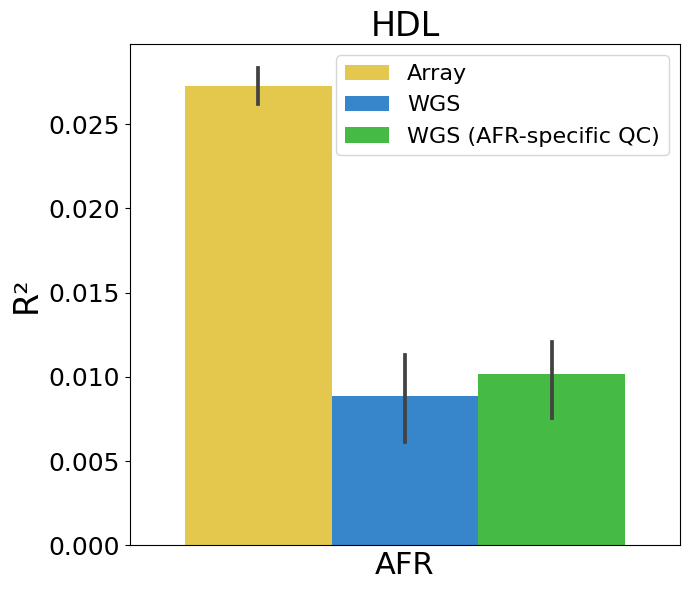

In [51]:
data = quant_df

# Choose a single phenotype to plot (e.g., 'HDL')
selected_pheno = 'HDL'

# Filter data for the selected phenotype
subset = data[data["pheno"] == selected_pheno]

# Create the plot for the selected phenotype
plt.figure(figsize=(7, 6))  # Adjust the size of the plot

sns.barplot(
    data=subset,
    x="Ancestry",
    y="R2",
    hue="Source",
    palette=["#FDD835", "#1E88E5", "limegreen"]  # Customize the color palette
)

# Set title and labels
plt.title(f"{selected_pheno}", fontsize=24)
plt.xlabel("AFR", fontsize=22)  
plt.ylabel("R²", fontsize=24)

# Remove x-axis ticks
plt.xticks([])  # This will remove the x-axis tick marks

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=18)

# Adjust the legend
plt.legend(title="", loc="upper right", fontsize=16)

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Check AFR AF

In [5]:
mt_wgs_path = os.getenv("WGS_HAIL_STORAGE_PATH")
mt_wgs = hl.read_matrix_table(mt_wgs_path)
mt_wgs = mt_wgs.key_rows_by("locus")

In [6]:
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_wgs = mt_wgs.semi_join_cols(Sample_quant)
mt_wgs = mt_wgs.annotate_cols(**Sample_quant[mt_wgs.s])

2024-11-19 17:47:41.336 Hail: INFO: Reading table to impute column types 1) / 1]
2024-11-19 17:47:48.374 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [ ]:
# subset to AFR QC'ed HDL clumped variants
mt_wgs_afr = mt_wgs.filter_cols(mt_wgs.is_anc_pred_afr == 1)
var_wgs_HDL_afr = hl.read_table(f'{bucket}/Sumstats_clumped/WGS_HDL_afr_clumps_var.ht')
var_wgs_HDL_afr = var_wgs_HDL_afr.key_by('locus')
mt_wgs_afr = mt_wgs_afr.semi_join_rows(var_wgs_HDL_afr)
mt_wgs_afr = mt_wgs_afr.annotate_rows(allele_freq=hl.agg.mean(mt_wgs_afr.GT.n_alt_alleles()) / 2)
mt_wgs_afr.rows().write(f"{bucket}/AF/wgs_afr_QC_HDL_clump.ht", overwrite=True)